# Regression Discontinuity

ECON526

Paul Schrimpf (University of British Columbia)

# Introduction

$$
\def\indep{\perp\!\!\!\perp} % \def\idp{\perp\kern-5pt\perp}
\def\Er{\mathrm{E}}
\def\var{\mathrm{Var}}
\def\cov{\mathrm{Cov}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\def\inprob{{\,{\buildrel p \over \rightarrow}\,}}
\def\indist{\,{\buildrel d \over \rightarrow}\,}
\DeclareMathOperator*{\plim}{plim}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

# Sharp Discontinuity

## Regression Discontinuity

-   Treatment $D_i \in \{0,1\}$
-   Potential outcomes $Y_i(d)$
-   Running variable $R_i$, treatment assignment discontinuous in $r$ at
    cutoff $c$
    -   Sharp: $P(D|R)$ jumps from 0 to 1
    -   Fuzzy: $P(D|R)$ jumps

``` python
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

def pdr(r):
    if (r < 0):
        return 0 #0.2/(1+np.exp(-r))
    else:
        return 1 # 0.8/(1+0.5*np.exp(-r))

def plotp(ax, pdr):
    r = np.linspace(-2,2,500)
    ax.plot(r, list(map(pdr,r)), color='C0')
    ax.set_xlabel('R')
    ax.set_ylabel('Pr(D=1|R)')
    return(ax)
fig, ax = plt.subplots(figsize=(5,5))
ax = plotp(ax,pdr)
```

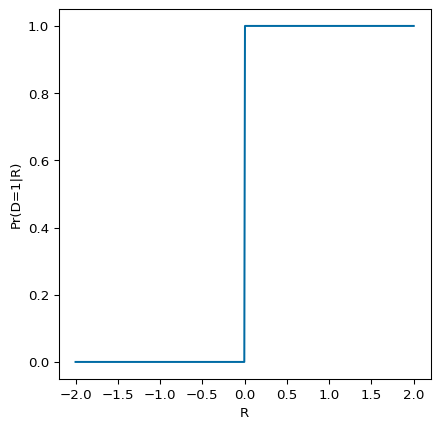

## Running Variables and Discontinuities

-   Usually come from institutional rules
-   Treatment / program eligibility changes discretely with $R$
-   Common running variables:
    -   Geographic location
    -   Income, wealth
    -   Test scores
    -   Votes
    -   Age

## Continuous Potential Outcomes

-   Assume continuity: $$\Er[Y(1)|R=r]$$ and $$\Er[Y(0)|R=r]$$ are
    continuous in $r$
-   Observed $$
    \begin{align*}
    \Er[Y|R] = & \Pr(D=1|R)\Er[Y(1)|R,D=1] + \\ & + \Pr(D=0|R)\Er[Y(0)|R,D=0]
    \end{align*}
    $$
-   Idea: size of discontinuity in $\Er[Y|R]$ is related to a treatment
    effect

``` python
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

def Ey(d,r) :
    if d < 0.1 :
        return 0.5*(r+0.2)**3 + 0.1*(r+0.2)**2
    else :
        return 2 + 0.3*r**3 + r

fig, ax = plt.subplots(2,1, figsize=(4,7))
ax[0] = plotp(ax[0],pdr)

def plotey(ax,Ey,pdr) :
    r = np.linspace(-2,-0.01,100)
    ax.plot(r, list(map(lambda r: Ey(0,r),r)), color='C0', label="E[Y(0)|R]")
    r = np.linspace(2,0.01,100)
    ax.plot(r, list(map(lambda r: Ey(0,r),r)), color='C0', linestyle=":")
    r = np.linspace(-2,-0.01,100)
    ax.plot(r, list(map(lambda r: Ey(1,r),r)), color='C1', linestyle=":")
    r = np.linspace(2,0.01,100)
    ax.plot(r, list(map(lambda r: Ey(1,r),r)), color='C1', label="E[Y(1)|R]")
    r = np.linspace(-2,2,200)
    ax.plot(r,list(map(lambda r: pdr(r)*Ey(1,r) + (1-pdr(r))*Ey(0,r),r)), color='C2', label="E[Y|R]", linestyle="--", alpha=0.8)
    ax.legend()
    ax.set_xlabel('R')
    ax.set_ylabel('E[Y(d)|R]')
    return(ax)

ax[1] = plotey(ax[1],Ey,pdr)
```

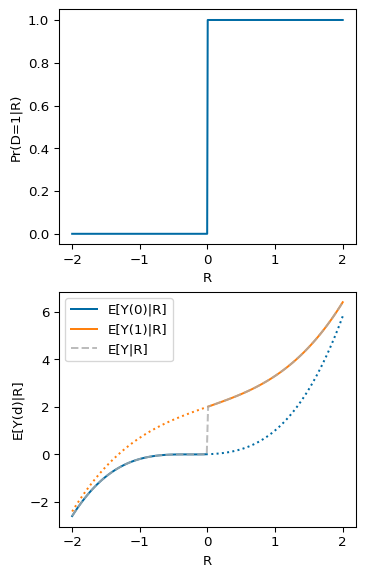

## Identification

-   Size of disconuity in $\Er[Y|R]$ $$
    \begin{align*}
    \lim_{r \downarrow c} \Er[Y|R=r] - \lim_{r \uparrow c} \Er[Y|R=r] & = \lim_{r \downarrow c} \Er[Y(1)|R=r] - \lim_{r \uparrow c} \Er[Y(0),r)|R=r] \\
    & = \Er[Y(1) - Y(0) | R=c]
    \end{align*}
    $$
-   Identifies ATE conditional on being at the cutoff
-   Assuming:
    1.  Sharp discontinuity
        $P(D|R=r) = \begin{cases} 0 & \; r<c \\ 1 & r \geq c \end{cases}$
    2.  Continuity of $\Er[Y(1)|R=r]$ and $\Er[Y(0)|R=r]$

## Data

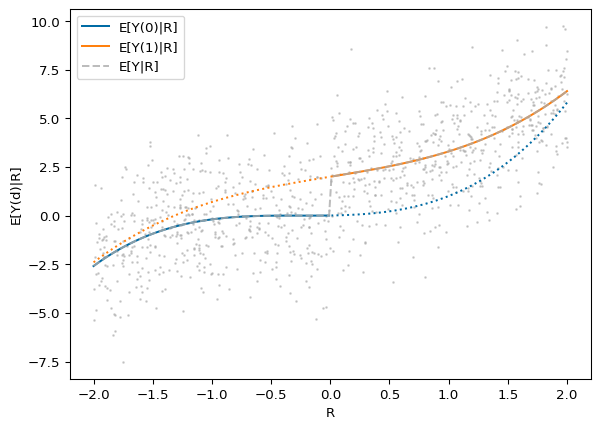

In [3]:
n = 1_000
sig = 2
fig,ax=plt.subplots()
r = np.random.rand(n)*4-2
y = np.vectorize(lambda r: Ey(np.sign(r)*2+1,r) + np.random.randn()*sig)(r)
ax =plotey(ax,Ey,pdr)
ax.scatter(r,y,color='C2', alpha=0.5,s=1)
plt.show()

## Estimation

-   Fit regression to left and right of discontinuity using only
    observations near the cutoffs

In [4]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

df = pd.DataFrame({'y':y,'r':r})

def rdd(df, h, c=0, R='r', Y='y') :
    wdf = df.loc[np.abs(df[R]-c)<=h]
    m=smf.ols(f'{Y} ~ I({R}-c)*I({R}>c)',wdf).fit(cov_type="HC3")
    return(m)

bandwidths=[.25, 0.5, 1., 2.]
models = [rdd(df,h) for h in bandwidths]
summary_col(models, model_names=[f"h={h:.2}" for h in bandwidths])

Standard errors in parentheses.

## Plotting Estimates

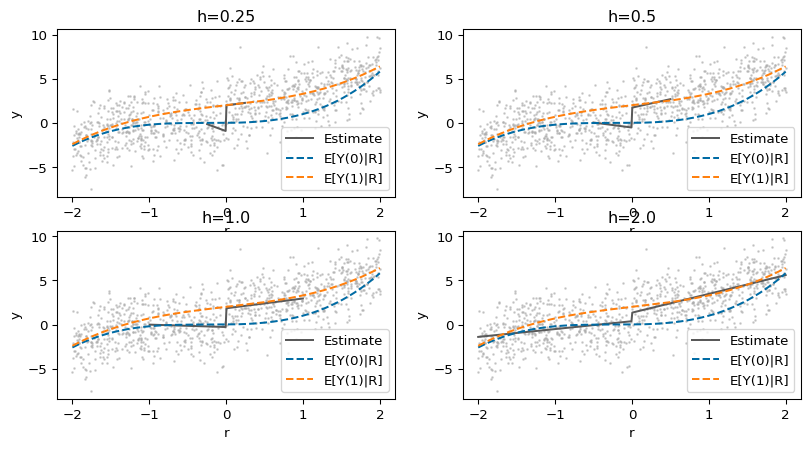

In [5]:
def plotrdd(ax,df, h, c=0, R='r',Y='y', Ey=Ey) :
    df = df.sort_values(R)
    m = rdd(df,h,c,R,Y)
    df.plot.scatter(x=R,y=Y,ax=ax,color="C2",alpha=0.5,s=1)
    df.assign(predictions=m.fittedvalues).plot(x=R, y="predictions",label='Estimate', ax=ax, color="C3")
    df.assign(Ey0=df[R].apply(lambda r: Ey(0,r))).plot(x=R,y='Ey0',label="E[Y(0)|R]",ax=ax,color="C0",linestyle="--")
    df.assign(Ey1=df[R].apply(lambda r: Ey(1,r))).plot(x=R,y='Ey1',label="E[Y(1)|R]",ax=ax,color="C1",linestyle="--")
    #ax.get_legend().remove()
    return(ax)

fig,ax = plt.subplots(2,2, figsize=(10,5))
for (i,h) in enumerate(bandwidths) :
    plotrdd(ax.flat[i],df,h)
    ax.flat[i].set_title(f"h={h:.2}")

## Questions

-   Is there a better way to visualize?
-   How to choose `h`?
-   Are these standard errors correct?
-   Are there any falsification or other checks to do?

## Binned Scatter Plot

-   Divide range of $R$ into bins, plot mean within each bin
-   Many papers just show binned means, but better to show uncertainty /
    variability in data too
    -   Two good options in `rdrobust` package:
        1.  `binselect='es'` or `qs'` and plot confidence intervals
        2.  `binselect='esmv'` or `'qsmv'`
-   See Cattaneo, Idrobo, and Titiunik (2019) section 3 and Cattaneo et
    al. (2024)

``` python
import rdrobust
rdp = rdrobust.rdplot(df.y,df.r,c=0,hide=True, binselect='es')
fg,ax=plt.subplots(figsize=(4,6))
pltdf = rdp.vars_bins
pltdf.plot.scatter(x='rdplot_mean_bin',y='rdplot_mean_y', color='black',ax=ax,label='IMSE optimal bins')
ax.set_xlabel('R')
ax.set_ylabel('Y')
ax.errorbar(x=pltdf.rdplot_mean_bin,y=pltdf.rdplot_mean_y,
             yerr=[pltdf.rdplot_mean_y-pltdf.rdplot_ci_l,pltdf.rdplot_ci_r - pltdf.rdplot_mean_y],
             ls='none',color="black")
rdp = rdrobust.rdplot(df.y,df.r,c=0,hide=True, binselect='esmv')
pltdf = rdp.vars_bins
pltdf.plot.scatter(x='rdplot_mean_bin',y='rdplot_mean_y', color='C4',ax=ax,label='Variance mimicking bins')
df.plot.scatter(x='r',y='y',color='C2',s=1,alpha=0.5,label=None,ax=ax)
ax.legend()
plt.show()
```

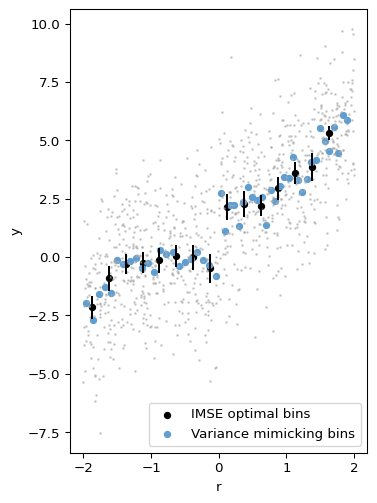

## Bandwidth Selection

-   Bandwith, `h`, has bias variance tradeoff
-   Larger `h` $\Rightarrow$ lower variance, higher bias
-   Smaller `h` $\Rightarrow$ higher variance, lower bias
-   Optimal `h` balances bias and variance
-   Optimal `h` will decrease with sample size

## Bandwidth Selection

In [7]:
rd = rdrobust.rdrobust(df.y,df.r, kernel="uniform",  bwselect="msetwo")
rd

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                               Uniform
Bandwidth Selection:                   msetwo
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           494        506
Number of Unique Obs.            494        506
Number of Effective Obs.         109        163
Bandwidth Estimation            0.48      0.676
Bandwidth Bias                 0.878       1.19
rho (h/b)                      0.546      0.568

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       2.421    0.596    4.062   4.875e-05     [1.253, 3.589]
Robust                 -        -     3.68   2.331e-04     [1.205, 3.952]

## Confidence Intervals

-   Optimal `h` has $\mathrm{Bias}^2 = \var$
-   Need to correct for bias for confidence intervals to be correct
-   Use “Robust” interval reported by `rdrobust`
-   See section 4.3 of Cattaneo, Idrobo, and Titiunik (2019)

## Kernel Weighting

-   Instead of treating all observations within bandwith as equally
    important for estimating discontinuity, we might want to weight
    observations closer to discontinuity more
-   “triangular” kernel is best

``` python
rd = rdrobust.rdrobust(df.y,df.r, kernel="triangular",  bwselect="msetwo")
rd
```

    Call: rdrobust
    Number of Observations:                  1000
    Polynomial Order Est. (p):                  1
    Polynomial Order Bias (q):                  2
    Kernel:                            Triangular
    Bandwidth Selection:                   msetwo
    Var-Cov Estimator:                         NN

                                    Left      Right
    ------------------------------------------------
    Number of Observations           494        506
    Number of Unique Obs.            494        506
    Number of Effective Obs.         106        200
    Bandwidth Estimation           0.461      0.815
    Bandwidth Bias                 0.774      1.253
    rho (h/b)                      0.596       0.65

    Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
    -------------------------------------------------------------------------
    Conventional       2.906    0.638    4.553   5.300e-06     [1.655, 4.157]
    Robust                 -        -    4.224   2.397e-05      [1.699, 4.64]

## Manipulation of Running Variable

-   If units can change $R_i$, they might do in way to change treatment
    status
-   Manipulation of $R_i$ makes continuity of $\Er[Y(d)|R]$ less
    plausible
-   Check for bunching in density of $R_i$ near cutoff

## Manipulation of Running Variable

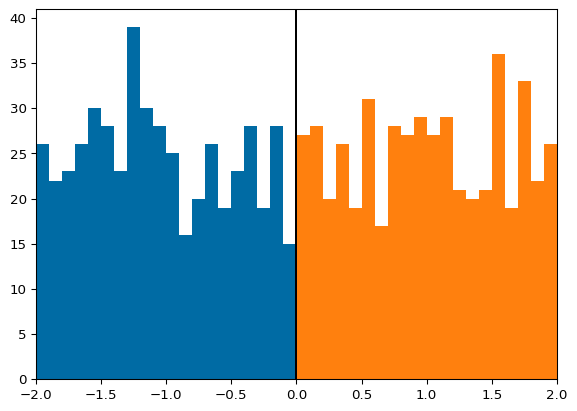

In [9]:
fig,ax=plt.subplots()
ax.hist(x=df.r[df.r<=0],bins=20,color="C0")
ax.hist(x=df.r[df.r>0],bins=20,color="C1")
ax.set_xlim(-2,2)
ax.axvline(0,color="black")
plt.show()

## Placebo Tests

-   If have data on outcomes not affected by treatment (e.g. if
    predetermined) can check that RD estimate for them is 0

``` python
df.x = np.sin(2*df.r)*np.exp(0.5*df.r) + np.random.randn(df.shape[0])
rdx = rdrobust.rdrobust(df.x,df.r, kernel="triangular",  bwselect="msetwo")
rdx
```

    Call: rdrobust
    Number of Observations:                  1000
    Polynomial Order Est. (p):                  1
    Polynomial Order Bias (q):                  2
    Kernel:                            Triangular
    Bandwidth Selection:                   msetwo
    Var-Cov Estimator:                         NN

                                    Left      Right
    ------------------------------------------------
    Number of Observations           494        506
    Number of Unique Obs.            494        506
    Number of Effective Obs.         134        101
    Bandwidth Estimation            0.61      0.404
    Bandwidth Bias                 1.092      0.692
    rho (h/b)                      0.559      0.583

    Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
    -------------------------------------------------------------------------
    Conventional       0.458    0.334    1.372   1.702e-01    [-0.197, 1.113]
    Robust                 -        -    1.248   2.120e-01    [-0.279, 1.256]

    /tmp/ipykernel_148888/2044443851.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access

## Placebo Tests

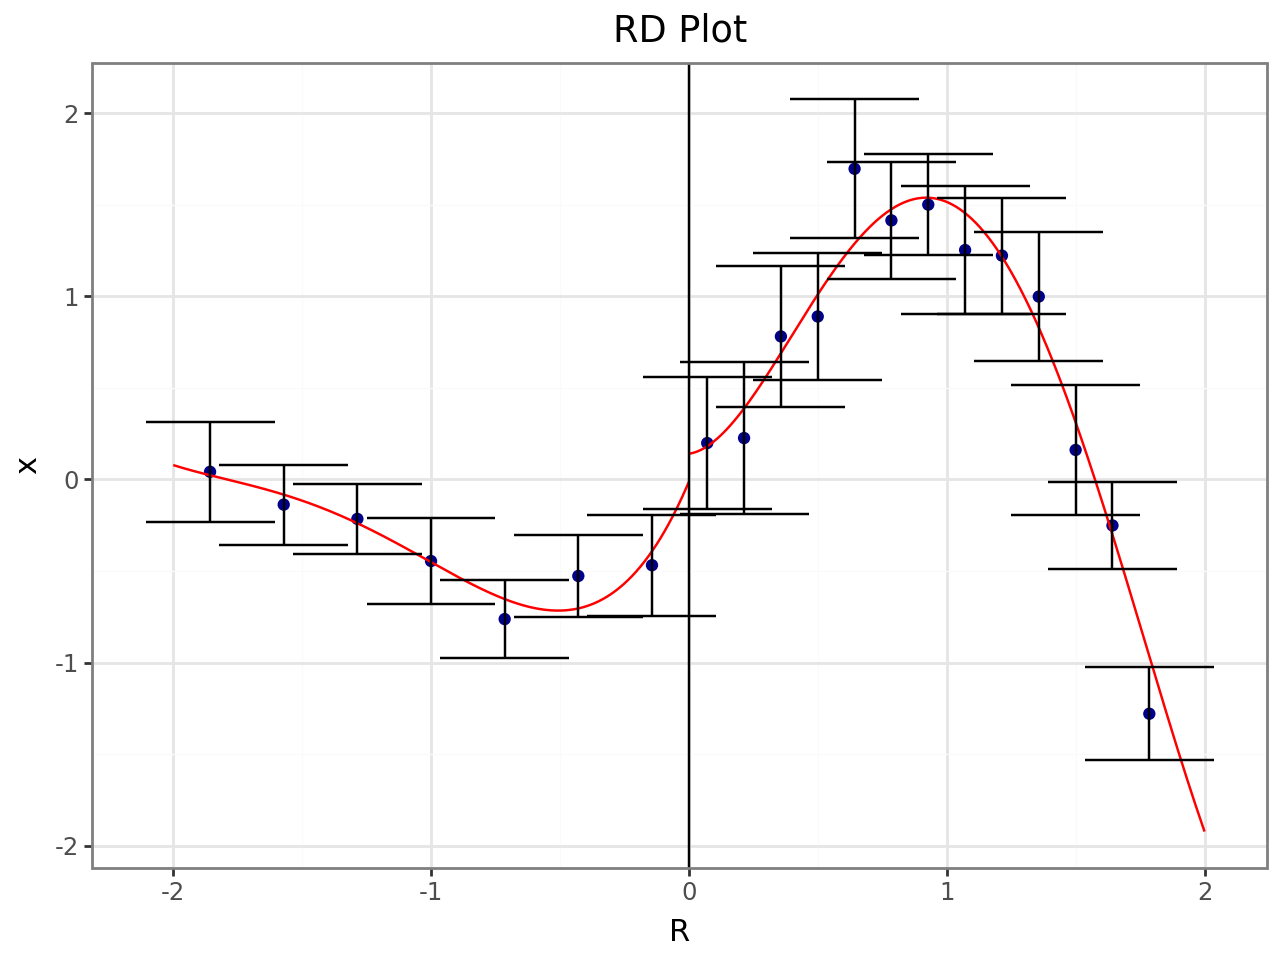

In [11]:
rdpx = rdrobust.rdplot(df.x,df.r,c=0,hide=False, binselect='es',x_label="R",y_label="x",ci=95)

# Fuzzy Discontinuity

## Fuzzy Discontinuity

-   $P(D|R)$ discontinuous at $c$
-   imperfect compliance
-   Idea: use discontinuity as instrument for treatment

``` python
def pdr(r):
    if (r < 0):
        return 0.2/(1+np.exp(-r))
    else:
        return 0.8/(1+0.5*np.exp(-r))

fig, ax = plt.subplots(figsize=(5,5))
ax = plotp(ax,pdr)
```

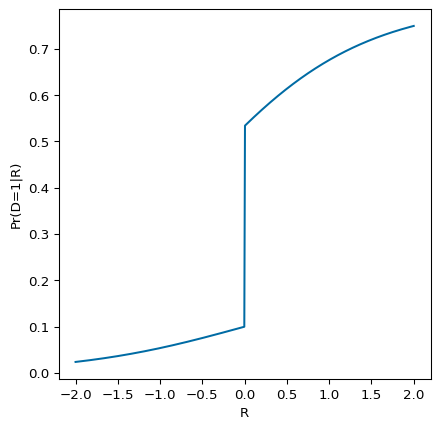

## Merit Based Financial Aid for Low-Income Students

-   Londoño-Vélez, Rodríguez, and Sánchez (2020) (also used as example
    in Cattaneo, Idrobo, and Titiunik (2024))
-   Full undergraduate tuition available if
    1.  Standardized test $\geq$ 91%-tile
    2.  Wealth index $\leq$ cutoff(region)
-   Two discontinuities
-   Outcome $=$ postsecondary enrollment
-   Focus on wealth cutoff

## Merit Based Financial Aid for Low-Income Students

In [13]:
lrs_all = pd.read_stata('data/data_RD.dta')
lrs = lrs_all.loc[lrs_all.eligible_saber11==1] #
lrs.columns

Index(['running_saber11_placebo', 'running_saber11', 'running_sisben',
       'eligible_saber11', 'eligible_sisben', 'eligible_spp', 'sisben_area',
       'sisben_score', 'beneficiary_spp', 'spadies_any', 'spadies_hq',
       'spadies_lq', 'spadies_hq_pub', 'spadies_hq_pri', 'spadies_lq_pub',
       'spadies_lq_pri', 'spadies_hq_id', 'icfes_per', 'icfes_female',
       'icfes_age', 'icfes_urm', 'icfes_stratum', 'icfes_stratum1',
       'icfes_stratum2', 'icfes_stratum3', 'icfes_stratum4', 'icfes_stratum5',
       'icfes_stratum6', 'icfes_educm1', 'icfes_educm2', 'icfes_educm3',
       'icfes_educm4', 'icfes_educp1', 'icfes_educp2', 'icfes_educp3',
       'icfes_educp4', 'icfes_famsize', 'icfes_works', 'icfes_privatehs',
       'icfes_schoolsch1', 'icfes_schoolsch2', 'icfes_schoolsch3',
       'icfes_schoolsch4', 'icfes_schoolsch5', 'icfes_score_20132',
       'icfes_score_20142'],
      dtype='object')

## First Stage: Effect on Receiving Tuition Subsidy

Mass points detected in the running variable.

/home/paul/526/mine/site/.venv/lib/python3.12/site-packages/rdrobust/rdplot.py:521: RuntimeWarning: invalid value encountered in divide
/home/paul/526/mine/site/.venv/lib/python3.12/site-packages/rdrobust/rdplot.py:535: RuntimeWarning: invalid value encountered in scalar divide
/home/paul/526/mine/site/.venv/lib/python3.12/site-packages/rdrobust/rdplot.py:536: RuntimeWarning: invalid value encountered in scalar divide
/home/paul/526/mine/site/.venv/lib/python3.12/site-packages/rdrobust/rdplot.py:537: RuntimeWarning: invalid value encountered in scalar divide
/home/paul/526/mine/site/.venv/lib/python3.12/site-packages/rdrobust/rdplot.py:538: RuntimeWarning: invalid value encountered in scalar divide

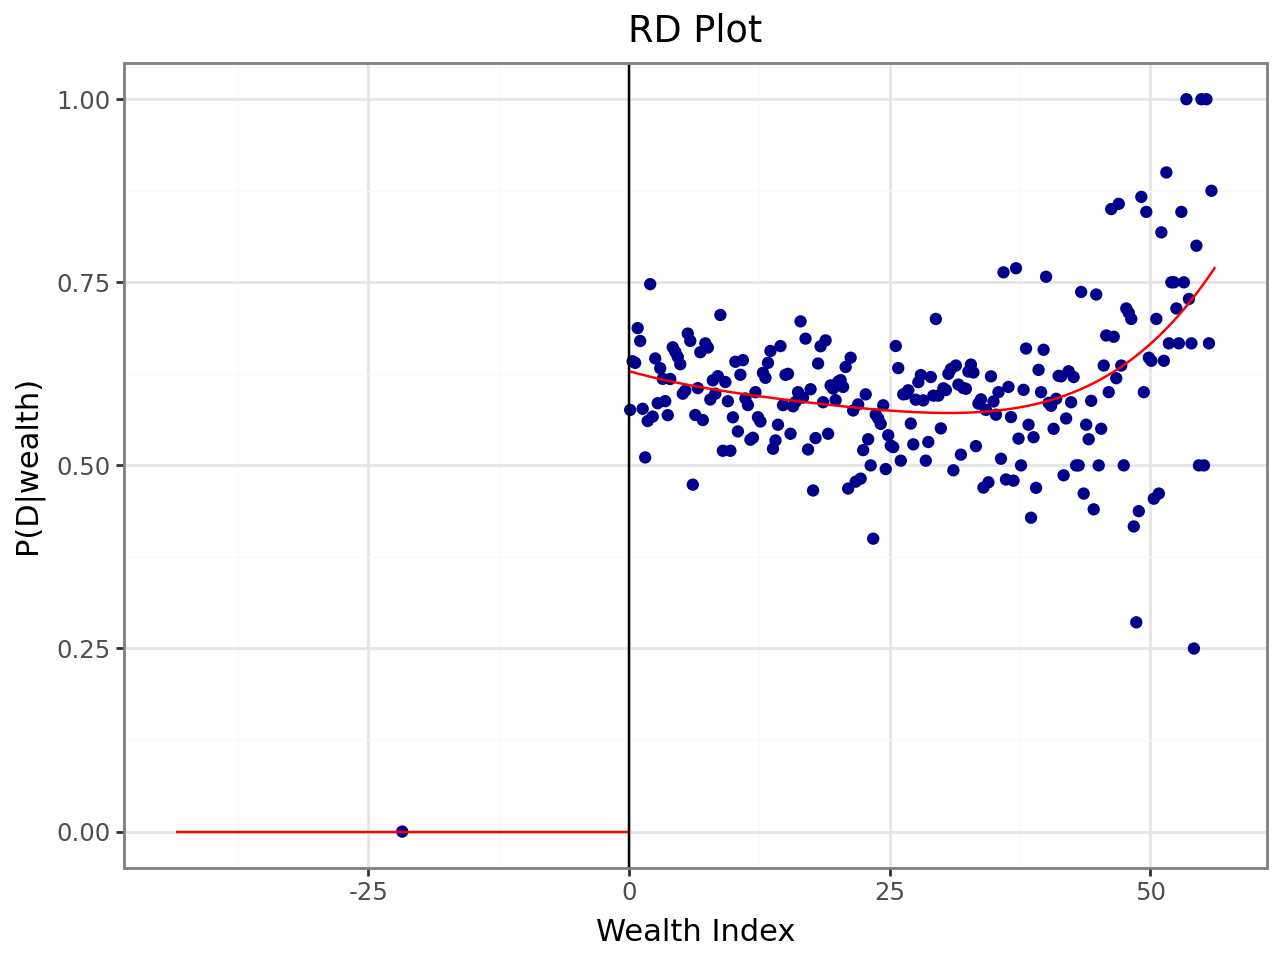

Call: rdplot
Number of Observations:                 23132
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations          7709      15423
Number of Effective Obs         7709      15423
Bandwith poly. fit (h)         43.48      56.23
Number of bins scale               1          1
Bins Selected                      1        234
Average Bin Length             43.48       0.24
Median Bin Length              43.48       0.24
IMSE-optimal bins                nan        8.0
Mimicking Variance bins          nan      234.0

Relative to IMSE-optimal:
Implied scale                    nan      29.25
WIMSE variance weight            nan        0.0
WIMSE bias weight                nan        1.0

In [14]:
df=lrs[["running_sisben","beneficiary_spp","icfes_score_20142","spadies_any","spadies_hq"]].dropna()
rdrobust.rdplot(df.beneficiary_spp, df.running_sisben, binselect='esmv', x_label="Wealth Index",y_label="P(D|wealth)")

## First Stage: Effect on Receiving Tuition Subsidy

In [15]:
fs = rdrobust.rdrobust(df.beneficiary_spp, df.running_sisben, kernel="triangular",  bwselect="mserd")
fs

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                 23132
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          7709      15423
Number of Unique Obs.           3644       9327
Number of Effective Obs.        6600       7466
Bandwidth Estimation           18.51      18.51
Bandwidth Bias                28.994     28.994
rho (h/b)                      0.638      0.638

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.625    0.012   51.592   0.000e+00     [0.601, 0.649]
Robust     

## Reduced Form: Effect on Postsecondary Enrollment

Mass points detected in the running variable.

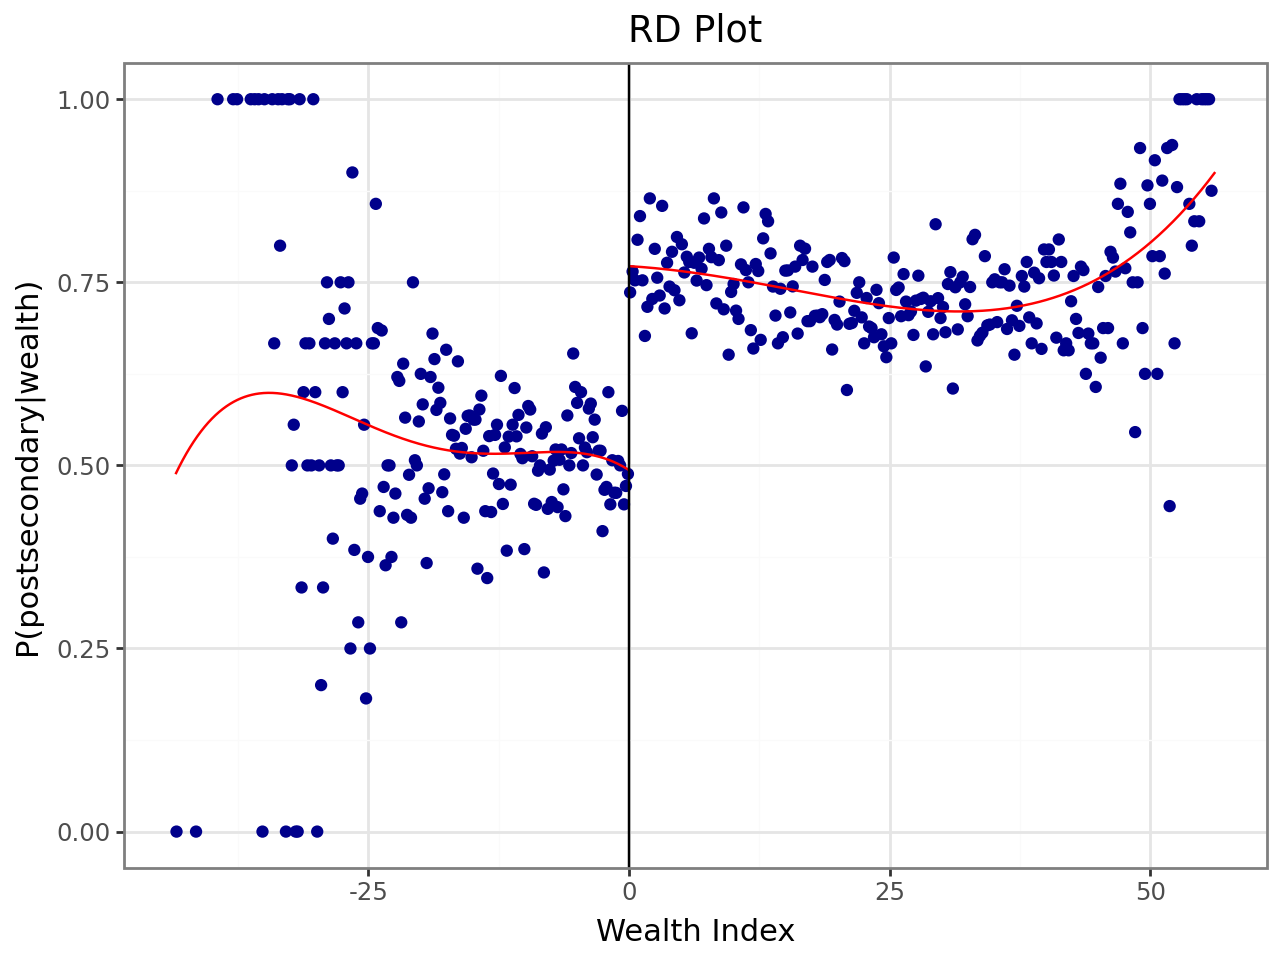

Call: rdplot
Number of Observations:                 23132
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations          7709      15423
Number of Effective Obs         7709      15423
Bandwith poly. fit (h)         43.48      56.23
Number of bins scale               1          1
Bins Selected                    232        238
Average Bin Length             0.196      0.236
Median Bin Length              0.187      0.236
IMSE-optimal bins                5.0        9.0
Mimicking Variance bins        232.0      238.0

Relative to IMSE-optimal:
Implied scale                   46.4     26.444
WIMSE variance weight            0.0        0.0
WIMSE bias weight                1.0        1.0

In [16]:
rdrobust.rdplot(df.spadies_any, df.running_sisben, binselect='esmv', x_label="Wealth Index",y_label="P(postsecondary|wealth)")

## Reduced Form: Effect on Postsecondary Enrollment

In [17]:
rf = rdrobust.rdrobust(df.spadies_any, df.running_sisben, kernel="triangular",  bwselect="mserd")
rf

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                 23132
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          7709      15423
Number of Unique Obs.           3644       9327
Number of Effective Obs.        3877       3908
Bandwidth Estimation           9.042      9.042
Bandwidth Bias                14.404     14.404
rho (h/b)                      0.628      0.628

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.269    0.023   11.709   1.144e-31     [0.224, 0.314]
Robust     

## Questions

-   How to get an IV estimate?
-   What causal interpretation can we give an IV estimate?

## Potential Outcomes

-   “Assigned treatment $A_i = 1\{R_i > c\}$
-   Potential treatments $D_i(A_i) \in \{0,1\}$
-   Potential outcomes $Y_i(a, d)$
-   Observed outcome $Y_i(A_i,D_i(A_i))$
-   Exclusion restriction: $R_i$ does not affect treatment or outcome,
    except through $A_i$

## LATE

-   Assume monotonicity: $D_i(1) \geq D_i(0)$ $$
    \frac{\text{reduced form}}{\text{first stage}} \inprob \Er[Y(1) - Y(0) | wealth=c_w, test>c_t, D_i(1)>D_i(0)]
    $$
-   Optimal bandwidth choice different
-   Use `rdrobust` for bandwidth selection and confidence intervals

## LATE

In [18]:
late = rdrobust.rdrobust(df.spadies_any, df.running_sisben, fuzzy=df.beneficiary_spp)
late

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                 23132
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          7709      15423
Number of Unique Obs.           3644       9327
Number of Effective Obs.        3877       3908
Bandwidth Estimation           9.042      9.042
Bandwidth Bias                14.404     14.404
rho (h/b)                      0.628      0.628

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.434    0.034   12.773   2.322e-37     [0.368, 0.501]
Robust     

## Sources and Further Reading

-   Facure (2022) [chapter
    16](https://matheusfacure.github.io/python-causality-handbook/16-Regression-Discontinuity-Design.html)
-   Chernozhukov et al. (2024) chapter 17
-   Cattaneo, Idrobo, and Titiunik (2019) and Cattaneo, Idrobo, and
    Titiunik (2024)
-   https://rdpackages.github.io/

## References

Cattaneo, Matias D., Richard K. Crump, Max H. Farrell, and Yingjie Feng.
2024. “On Binscatter.” *American Economic Review* 114 (5): 1488–1514.
<https://doi.org/10.1257/aer.20221576>.

Cattaneo, Matias D., Nicolas Idrobo, and Rocío Titiunik. 2024. *A
Practical Introduction to Regression Discontinuity Designs: Extensions*.
Cambridge University Press. <https://doi.org/10.1017/9781009441896>.

Cattaneo, Matias D., Nicolás Idrobo, and Rocío Titiunik. 2019. *A
Practical Introduction to Regression Discontinuity Designs:
Foundations*. Cambridge University Press.
<https://doi.org/10.1017/9781108684606>.

Chernozhukov, V., C. Hansen, N. Kallus, M. Spindler, and V. Syrgkanis.
2024. *Applied Causal Inference Powered by ML and AI*.
<https://causalml-book.org/>.

Facure, Matheus. 2022. *Causal Inference for the Brave and True*.
<https://matheusfacure.github.io/python-causality-handbook/landing-page.html>.

Londoño-Vélez, Juliana, Catherine Rodríguez, and Fabio Sánchez. 2020.
“Upstream and Downstream Impacts of College Merit-Based Financial Aid
for Low-Income Students: Ser Pilo Paga in Colombia.” *American Economic
Journal: Economic Policy* 12 (2): 193–227.
<https://doi.org/10.1257/pol.20180131>.